# Data preprocessing

In [2]:
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

/home/mo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [5]:
# https://github.com/albu/albumentations
from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose
)

In [4]:
path = '/home/mo/Downloads/airbus/'
path_train = path + 'train/'

In [6]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [7]:
class AirbusDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, root, aug = False, mode='train'):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.aug = aug
        self.mode = 'test'
        if mode == 'train':
            self.mode = 'train'
            self.masks = pd.read_csv(str(path+'train_ship_segmentations.csv')).fillna(-1)
        if self.aug:
            self.transform = OneOf([
                                RandomRotate90(),
                                Transpose(),
                                Flip(),
                            ], p=0.3)
        else:
            self.transform = transforms.ToTensor()
        filenames = glob.glob(osp.join(path_train, '*.jpg'))
        for fn in filenames:
            self.filenames.append(fn)
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks
        for mask in img_masks:
            all_masks += rle_decode(mask)
        return all_masks
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = Image.open(self.filenames[index])
        ImageId = self.filenames[index].split('/')[-1]
        if self.mode == 'train':
            mask = self.get_mask(ImageId)
        if self.aug:
            if self.mode == 'train':
                data = {"image": np.array(image), "mask": mask}
            else:
                data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            if self.mode == 'train':
                return image, transformed['mask'][np.newaxis,:,:] 
            else:
                return image
        else:
            if self.mode == 'train':
                return self.transform(image), mask[np.newaxis,:,:] 
            return self.transform(image)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

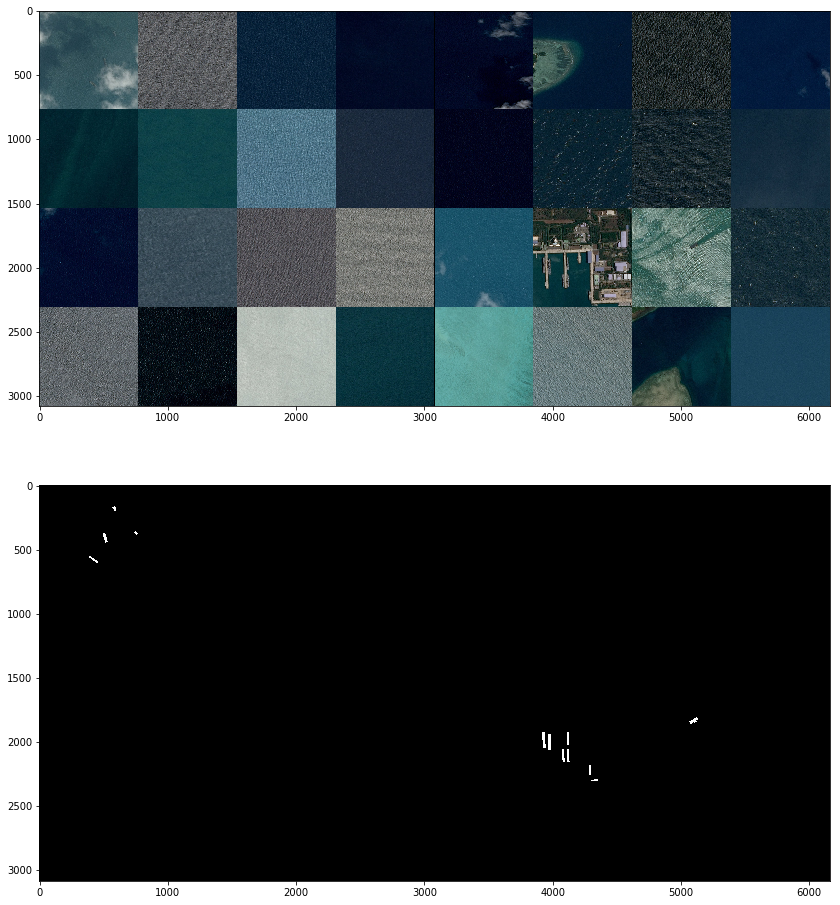

In [9]:
airimg = AirbusDS(path, aug=True, mode='train')
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(airimg, batch_size=32, shuffle=True, num_workers=0)

# get some images
dataiter = iter(loader)
images, masks = dataiter.next()

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
plt.figure(figsize=(16,16))
plt.subplot(211)
imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
imshow(torchvision.utils.make_grid(masks))